xmax=44.67458341589249, xmin=-19.171406060621653, R=63.84598947651415
mean=10.401667015550512, variance=79.08554873399855, std_dev=8.893005607442207, mu3=23.922604883382387, mu4=19074.925593761924, alpha=0.03401439641790748, median=10.393362632582036, mad=7.060555581631003


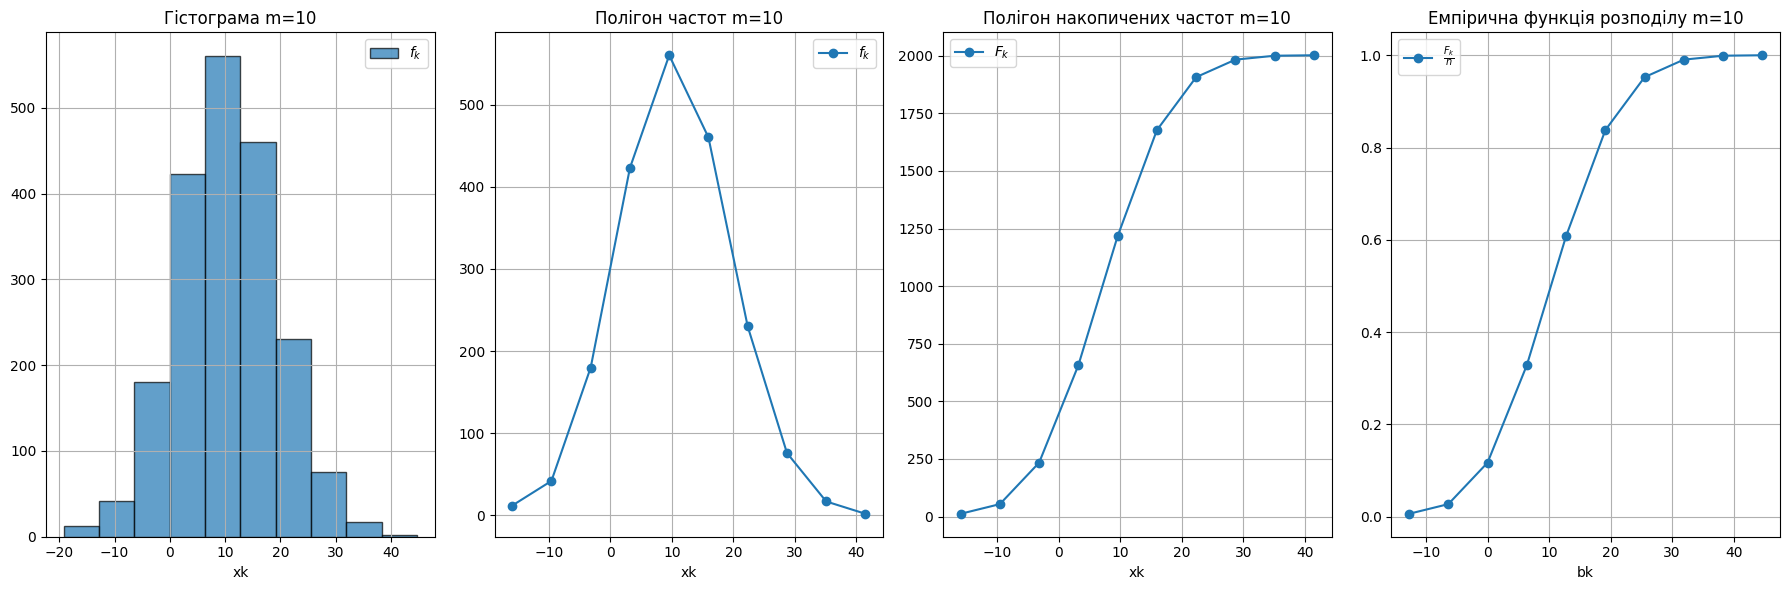

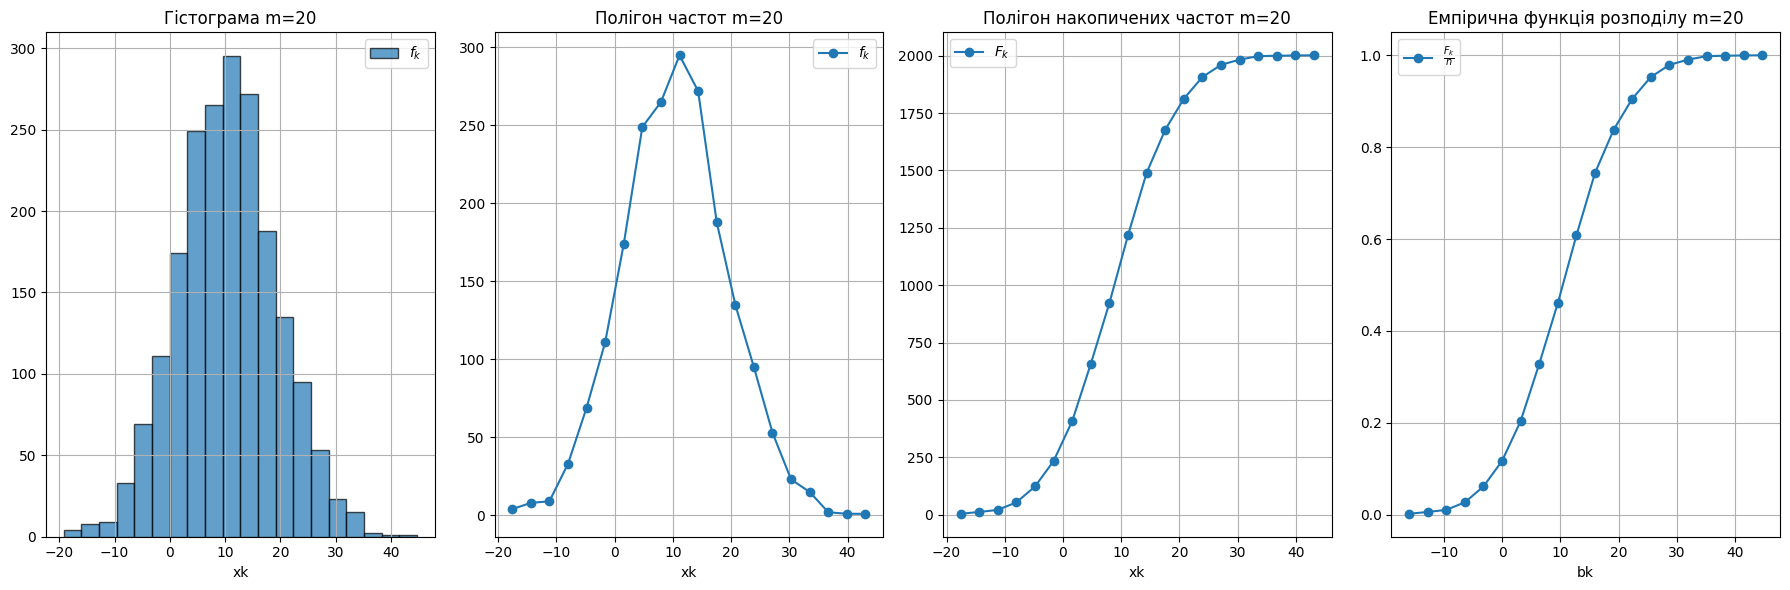

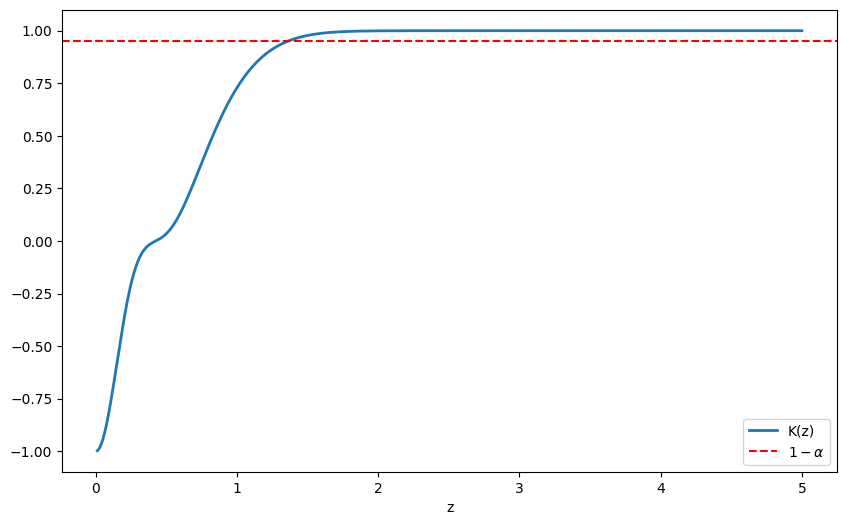

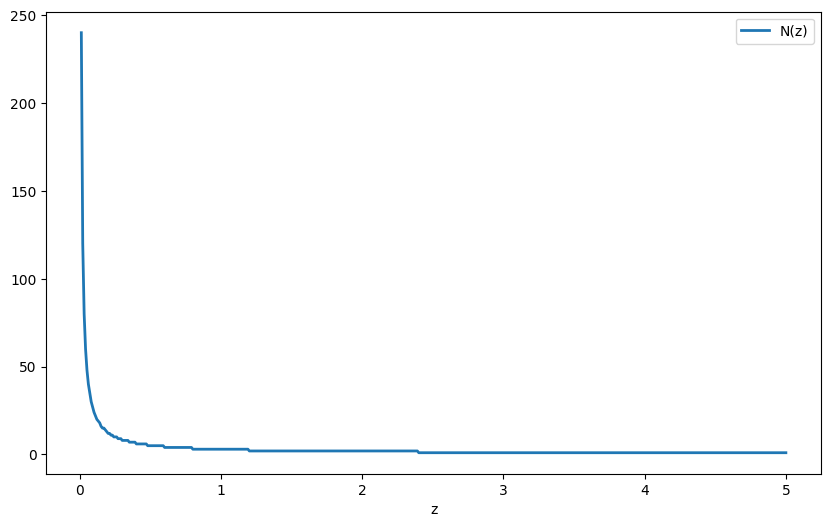

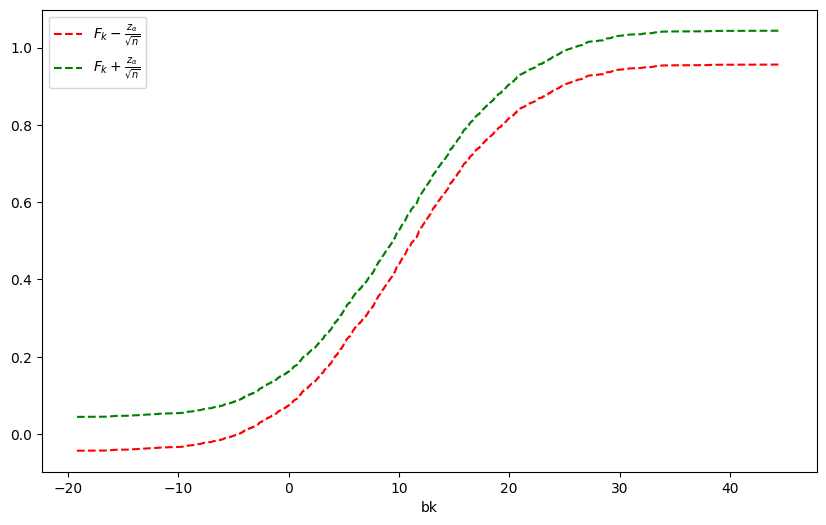

In [1]:
import math
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats


class SampleDistribution:
    def __init__(self, loc, scale, size, alpha=0.05):
        self.sample = np.random.normal(loc, scale, size)
        self.alpha = alpha
        self.n = len(self.sample)
        self.sample.sort()
        self.xmin, self.xmax = np.min(self.sample), np.max(self.sample)
        self.R = self.xmax - self.xmin

    def calculate_basic_statistics(self):
        mean = np.mean(self.sample)
        variance = np.var(self.sample, ddof=1)
        std_dev = np.sqrt(variance)
        mu3 = np.mean((self.sample - mean) ** 3)
        mu4 = np.mean((self.sample - mean) ** 4)
        alpha = mu3 / std_dev**3
        median = np.median(self.sample)
        mad = np.mean(np.abs(self.sample - median))
        return mean, variance, std_dev, mu3, mu4, alpha, median, mad

    def calculate_polygons(self, m):
        Delta = self.R / m
        j = np.arange(1, m + 1)
        xj = self.xmin + (Delta / 2) * (2 * j - 1)
        f, _ = np.histogram(self.sample, bins=m, range=(self.xmin, self.xmax))
        Fk = np.cumsum(f)
        aj = self.xmin + Delta * (j - 1)
        bj = aj + Delta
        return (xj, f, Fk, bj)

    def plot_generic_polygon(self, x, y, title, xlabel, plot_label, subplot_index):
        plt.subplot(1, 4, subplot_index)
        plt.plot(x, y, marker="o", linestyle="-", label=plot_label)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.grid()
        plt.legend()

    def plot_hystogram(self, x, bins, subplot_index):
        plt.subplot(1, 4, subplot_index)
        plt.hist(
            x,
            bins,
            label="$f_k$",
            range=(self.xmin, self.xmax),
            alpha=0.7,
            edgecolor="black",
        )
        plt.xlabel("xk")
        plt.title(f"Гістограма m={bins}")
        plt.grid()
        plt.legend()

    def plot_histogram_and_polygons(self, m):
        xj, f, Fk, bj = self.calculate_polygons(m)
        plt.figure(figsize=(18, 6))
        self.plot_hystogram(self.sample, bins=m, subplot_index=1)
        self.plot_generic_polygon(xj, f, f"Полігон частот {m=}", "xk", "$f_k$", 2)
        self.plot_generic_polygon(
            xj, Fk, f"Полігон накопичених частот {m=}", "xk", "$F_k$", 3
        )
        self.plot_generic_polygon(
            bj,
            Fk / self.n,
            f"Емпірична функція розподілу {m=}",
            "bk",
            "$\\frac{F_k}{n}$",
            4,
        )
        plt.tight_layout()
        plt.show()

    def plot_confidence_corridor(self):
        edf = np.arange(1, self.n + 1) / self.n
        delta_z = stats.norm.ppf(1 - self.alpha / 2) / np.sqrt(self.n)
        lower_bound, upper_bound = edf - delta_z, edf + delta_z
        plt.figure(figsize=(10, 6))
        plt.plot(
            self.sample,
            lower_bound,
            linestyle="--",
            color="red",
            label="$F_k - \\frac{z_\\alpha}{\\sqrt{n}}$",
        )
        plt.plot(
            self.sample,
            upper_bound,
            linestyle="--",
            color="green",
            label="$F_k + \\frac{z_\\alpha}{\\sqrt{n}}$",
        )
        plt.xlabel("bk")
        plt.legend()
        plt.show()

    @staticmethod
    def plot_kz_and_nz(z_values, alpha=0.05, N_val=3, epsilon=1e-5):
        K_values = [SampleDistribution.K(z, N_val) for z in z_values]
        N_values = [SampleDistribution.N(z, epsilon) for z in z_values]

        plt.figure(figsize=(10, 6))
        plt.plot(z_values, K_values, label="K(z)", linewidth=2)
        plt.axhline(1 - alpha, color="r", linestyle="--", label="$1 - \\alpha$")
        plt.xlabel("z")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(z_values, N_values, label="N(z)", linewidth=2)
        plt.xlabel("z")
        plt.legend()
        plt.show()

    @staticmethod
    def K(z, N_val):
        if z <= 0:
            return 0
        else:
            return np.sum(
                [
                    (-1) ** k * np.exp(-2 * k**2 * z**2)
                    for k in range(-N_val, N_val + 1)
                ]
            )

    @staticmethod
    def N(z, epsilon):
        return math.floor((1 / z) * np.sqrt(0.5 * np.log(1 / epsilon)) + 1)


def main():
    np.random.seed(42)
    xi = SampleDistribution(loc=10, scale=9, size=2002)
    xmax, xmin, R = xi.xmax, xi.xmin, xi.R
    print(f"{xmax=}, {xmin=}, {R=}")

    (
        mean,
        variance,
        std_dev,
        mu3,
        mu4,
        alpha,
        median,
        mad,
    ) = xi.calculate_basic_statistics()
    print(
        f"{mean=}, {variance=}, {std_dev=}, {mu3=}, {mu4=}, {alpha=}, {median=}, {mad=}"
    )

    xi.plot_histogram_and_polygons(m=10)
    xi.plot_histogram_and_polygons(m=20)
    z_values = np.linspace(0.01, 5, 500)

    SampleDistribution.plot_kz_and_nz(z_values)

    xi.plot_confidence_corridor()


if __name__ == "__main__":
    main()